# **MIE1626 Data Science Methods and Quantitative Analysis**

## **Project 1: Home Credit Default Risk**

**Details:**

**Name**: Rahul Gupta

**UtorId** : guptar77

**Student id** : 1008661958

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from patsy import dmatrices
import statsmodels.discrete.discrete_model as sm
import statsmodels.api as sm1
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets,linear_model
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,precision_score,recall_score,f1_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Kaggle dataset : https://www.kaggle.com/c/home-credit-default-risk/data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
application_train = pd.read_csv('/content/gdrive/MyDrive/Data for project MIE/application_train.csv')
POS_cash = pd.read_csv('/content/gdrive/MyDrive/Data for project MIE/POS_CASH_balance.csv')
bureau = pd.read_csv('/content/gdrive/MyDrive/Data for project MIE/bureau.csv')
bureau_bal = pd.read_csv('/content/gdrive/MyDrive/Data for project MIE/bureau_balance.csv')
credit_card_bal = pd.read_csv('/content/gdrive/MyDrive/Data for project MIE/credit_card_balance.csv')
installments = pd.read_csv('/content/gdrive/MyDrive/Data for project MIE/installments_payments.csv')



In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# **Section 1 Data Cleaning, Transforming and Visualization**

In [ ]:
########################################################## Section 1.1 Data Cleaning ############################################################

# Performing steps on Datsets before combining:


#### Data clean of bureau_balance dataset

bureau_bal = bureau_bal.drop(labels='MONTHS_BALANCE',axis=1)


In [ ]:
x1= bureau_bal.groupby('SK_ID_BUREAU').agg({'STATUS':'count'})
x1

,STATUS
SK_ID_BUREAU,
5001709,97
5001710,83
5001711,4
5001712,19
5001713,22
...,...
6842884,48
6842885,24
6842886,33


In [ ]:
x2= bureau_bal[bureau_bal['STATUS']=='0'].groupby('SK_ID_BUREAU').agg({'STATUS':'count'})
x2

,STATUS
SK_ID_BUREAU,
5001710,5
5001711,3
5001712,10
5001716,27
5001717,17
...,...
6842884,9
6842885,12
6842886,8


In [ ]:
bureau['SK_ID_BUREAU']

0          5714462
1          5714463
2          5714464
3          5714465
4          5714466
            ...   
1716423    5057750
1716424    5057754
1716425    5057762
1716426    5057770
1716427    5057778
Name: SK_ID_BUREAU, Length: 1716428, dtype: int64

In [ ]:
# Finding Proportions

bureau_bal_upd = x2.div(x1,level='STATUS')
bureau_bal_upd=bureau_bal_upd.fillna(0)
bureau_bal_upd['SK_ID_BUREAU']= bureau_bal_upd.index
bureau_bal_upd.index = range(817395)

bureau_bal_upd=bureau_bal_upd.rename(columns={'STATUS':'STATUS(Prop)'})
bureau_bal_upd

,STATUS(Prop),SK_ID_BUREAU
0,0.000000,5001709
1,0.060241,5001710
2,0.750000,5001711
3,0.526316,5001712
4,0.000000,5001713
...,...,...
817390,0.187500,6842884
817391,0.500000,6842885
817392,0.242424,6842886
817393,0.162162,6842887


In [ ]:
#### Bureau.csv data cleaning

bureau_upd = bureau.merge(bureau_bal_upd,how='left',on='SK_ID_BUREAU')
bureau_upd = bureau_upd.fillna(0)

x3 = bureau_upd.groupby('SK_ID_CURR').agg({'CREDIT_ACTIVE':'count'})
x4= bureau_upd[bureau_upd['CREDIT_ACTIVE']=='Closed'].groupby('SK_ID_CURR').agg({'CREDIT_ACTIVE':'count'})
x5= bureau_upd[bureau_upd['CREDIT_ACTIVE']=='Active'].groupby('SK_ID_CURR').agg({'CREDIT_ACTIVE':'count'})
bureau_upd_closed = x4.div(x3,level='CREDIT_ACTIVE')
bureau_upd_open =  x5.div(x3,level='CREDIT_ACTIVE')


In [ ]:
# Removal of irrelevant variables
bureau_upd= bureau_upd.drop(columns=['CREDIT_CURRENCY','DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE'])
bureau_upd

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,AMT_ANNUITY,STATUS(Prop)
0,215354,5714462,Closed,0.0,0,91323.00,0.0,0.0,0.0,Consumer credit,0.0,0.0
1,215354,5714463,Active,0.0,0,225000.00,171342.0,0.0,0.0,Credit card,0.0,0.0
2,215354,5714464,Active,0.0,0,464323.50,0.0,0.0,0.0,Consumer credit,0.0,0.0
3,215354,5714465,Active,0.0,0,90000.00,0.0,0.0,0.0,Credit card,0.0,0.0
4,215354,5714466,Active,77674.5,0,2700000.00,0.0,0.0,0.0,Consumer credit,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,0.0,0.0
1716424,100044,5057754,Closed,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,0.0,0.0
1716425,100044,5057762,Closed,0.0,0,15570.00,0.0,0.0,0.0,Consumer credit,0.0,0.0
1716426,246829,5057770,Closed,0.0,0,36000.00,0.0,0.0,0.0,Consumer credit,0.0,0.0


In [ ]:
# Proportion of Credit type

x6 = bureau_upd.groupby('SK_ID_CURR').agg({'CREDIT_TYPE':'count'})
x7= bureau_upd[bureau_upd['CREDIT_TYPE']=='Consumer credit'].groupby('SK_ID_CURR').agg({'CREDIT_TYPE':'count'})
x8= bureau_upd[bureau_upd['CREDIT_TYPE']=='Credit card'].groupby('SK_ID_CURR').agg({'CREDIT_TYPE':'count'})
bureau_upd_cons_crdt = x7.div(x6,level='CREDIT_TYPE')
bureau_upd_crd_card =  x8.div(x6,level='CREDIT_TYPE')



In [ ]:
bureau_upd_cons_crdt

,CREDIT_TYPE
SK_ID_CURR,
100001,1.000000
100002,0.500000
100003,0.500000
100004,1.000000
100005,0.666667
...,...
456249,0.692308
456250,0.666667
456253,0.750000


In [ ]:
# Join all 4 varibales

zxc= bureau_upd_open.merge(bureau_upd_closed,how='left',on='SK_ID_CURR')
xc = bureau_upd_cons_crdt.merge(bureau_upd_crd_card,how='left',on='SK_ID_CURR')
vari = zxc.merge(xc,how='left',on='SK_ID_CURR')
transformed_var = vari.reset_index()
transformed_var = transformed_var.fillna(0)
transformed_var = transformed_var.rename(columns={'CREDIT_ACTIVE_x':'CRDT_ACTIVE_PROP','CREDIT_ACTIVE_y':'CRDT_CLOSED_PROP','CREDIT_TYPE_x':'CONS_CRDT_PROP','CREDIT_TYPE_y':'CRDT_CARD_PROP'})
transformed_var



,SK_ID_CURR,CRDT_ACTIVE_PROP,CRDT_CLOSED_PROP,CONS_CRDT_PROP,CRDT_CARD_PROP
0,100001,0.428571,0.571429,1.000000,0.000000
1,100002,0.250000,0.750000,0.500000,0.500000
2,100003,0.250000,0.750000,0.500000,0.500000
3,100004,0.000000,1.000000,1.000000,0.000000
4,100005,0.666667,0.333333,0.666667,0.333333
...,...,...,...,...,...
305806,456249,0.153846,0.846154,0.692308,0.230769
305807,456250,0.666667,0.333333,0.666667,0.333333
305808,456253,0.500000,0.500000,0.750000,0.250000
305809,456254,0.000000,1.000000,1.000000,0.000000


In [ ]:
bureau_upd_1 = bureau_upd.groupby('SK_ID_CURR',as_index=False).agg({'AMT_CREDIT_MAX_OVERDUE':'mean','CNT_CREDIT_PROLONG':'mean','AMT_CREDIT_SUM':'mean','AMT_CREDIT_SUM_DEBT':'mean','AMT_CREDIT_SUM_LIMIT':'mean','AMT_CREDIT_SUM_OVERDUE':'mean','AMT_ANNUITY':'mean','STATUS(Prop)':'mean'})
bureau_upd_1 = bureau_upd_1.merge(transformed_var,how='left',on='SK_ID_CURR')
bureau_upd_1 # final dataset

,SK_ID_CURR,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY,STATUS(Prop),CRDT_ACTIVE_PROP,CRDT_CLOSED_PROP,CONS_CRDT_PROP,CRDT_CARD_PROP
0,100001,0.000000,0.000000,2.076236e+05,85240.928571,0.000000,0.0,3545.357143,0.336651,0.428571,0.571429,1.000000,0.000000
1,100002,1050.643125,0.000000,1.081319e+05,30722.625000,3998.570625,0.0,0.000000,0.406960,0.250000,0.750000,0.500000,0.500000
2,100003,0.000000,0.000000,2.543501e+05,0.000000,202500.000000,0.0,0.000000,0.000000,0.250000,0.750000,0.500000,0.500000
3,100004,0.000000,0.000000,9.451890e+04,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
4,100005,0.000000,0.000000,2.190420e+05,189469.500000,0.000000,0.0,1420.500000,0.735043,0.666667,0.333333,0.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,2364.230769,0.000000,2.841430e+05,12543.923077,0.000000,0.0,0.000000,0.000000,0.153846,0.846154,0.692308,0.230769
305807,456250,0.000000,0.000000,1.028820e+06,744013.365000,19422.795000,0.0,154567.965000,0.130259,0.666667,0.333333,0.666667,0.333333
305808,456253,0.000000,0.000000,9.900000e+05,448958.250000,0.000000,0.0,43777.125000,0.404906,0.500000,0.500000,0.750000,0.250000
305809,456254,0.000000,0.000000,4.500000e+04,0.000000,0.000000,0.0,0.000000,0.216216,0.000000,1.000000,1.000000,0.000000


In [ ]:

installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
##### Installment.csv data cleaning

installments['dummy'] = (installments['AMT_PAYMENT'] >= installments['AMT_INSTALMENT']).astype(int)
installments=installments.rename(columns={'dummy':'INSTALLMENT_PAID'})
#installments = installments.drop(columns=['AMT_INSTALMENT','AMT_PAYMENT'])

inst_max= installments.groupby('SK_ID_CURR',as_index=False).agg({'INSTALLMENT_PAID':'max'}) # Final data




In [ ]:
# Data cleaning of Credit card balance
credit_card_bal =credit_card_bal.fillna(0)
credit_card_bal_upd = credit_card_bal.groupby('SK_ID_CURR',as_index= False).agg({'AMT_DRAWINGS_ATM_CURRENT':'mean', 'AMT_DRAWINGS_CURRENT':'mean', 'AMT_DRAWINGS_OTHER_CURRENT':'mean',
'AMT_DRAWINGS_POS_CURRENT':'mean', 'AMT_RECIVABLE':'mean','AMT_TOTAL_RECEIVABLE':'mean'})
credit_card_bal_upd


,SK_ID_CURR,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE
0,100006,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,100011,2432.432432,2432.432432,0.0,0.000000,54433.179122,54433.179122
2,100013,5953.125000,5953.125000,0.0,0.000000,18101.079844,18101.079844
3,100021,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,100023,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
103553,456244,24475.609756,26842.388049,0.0,2363.015854,130767.060732,130767.060732
103554,456246,0.000000,15199.256250,0.0,15199.256250,12897.894375,12897.894375
103555,456247,2136.315789,2149.506474,0.0,13.190684,23128.243105,23128.243105
103556,456248,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [ ]:
# data cleaning of POS_CASH_balance.csv

POS_cash['SK_DPD'].fillna(0)
POS_cash['CNT_INSTALMENT_FUTURE'].fillna(0)
POS_cash['SK_DPD'] = POS_cash['SK_DPD'].where(POS_cash['SK_DPD']==0,1) ##Reference 4
POS_cash_grpby= POS_cash.groupby('SK_ID_CURR',as_index=False)
POS_cash_1 = POS_cash_grpby.agg({'SK_DPD':'max','CNT_INSTALMENT_FUTURE':'mean'})
POS_cash_1

,SK_ID_CURR,SK_DPD,CNT_INSTALMENT_FUTURE
0,100001,1,1.444444
1,100002,0,15.000000
2,100003,0,5.785714
3,100004,0,2.250000
4,100005,0,7.200000
...,...,...,...
337247,456251,0,4.375000
337248,456252,0,3.000000
337249,456253,1,2.000000
337250,456254,0,10.350000


In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# MERGE of all transformed data set with training dataset.

application_train = application_train.merge(bureau_upd_1,how='left',on='SK_ID_CURR')
application_train = application_train.merge(inst_max,how='left',on='SK_ID_CURR')
application_train = application_train.merge(credit_card_bal_upd,how='left',on='SK_ID_CURR')
application_train = application_train.merge(POS_cash_1,how='left',on='SK_ID_CURR')



In [ ]:
application_train.shape

(307511, 143)

**Ans**:   

Shape of dataset: **(307511,143)**


**DATA DICTIONARY:**

[ Variable: descriptions ]

STATUS(Prop): Indication of 'good' status of credit bureau loan

CRDT_ACTIVE_PROP = Indication of active credit status

CRDT_CLOSED_PROP = Indication of closed credit statatus

CONS_CRDT_PROP = Indication of proportionof Consumer credit in credit type

CRDT_CARD_PROP = Indication of Credit card in credit type.

AMT_CREDIT_MAX_OVERDUE	= Maximum amount of overdueon Credit Bureau per SkID

CNT_CREDIT_PROLONG	= No of time redit bureau prolonged

AMT_CREDIT_SUM	 = Current credit amount for the Credit Bureau credit

AMT_CREDIT_SUM_DEBT	= Current debt on Credit Bureau credit

AMT_CREDIT_SUM_LIMIT	= Current credit limit of credit card reported in Credit Bureau

AMT_CREDIT_SUM_OVERDUE	= Current amount overdue on Credit Bureau credit

AMT_ANNUITY = Annuity of the Credit Bureau credit

INSTALLMENT PAID ( Dummy variable created) = Whether client has paid installment on time or not.

AMT_DRAWINGS_ATM_CURRENT = Amount drawing at ATM during the month of the previous credit

AMT_DRAWINGS_CURRENT	=  Amount drawing during the month of the previous credit

AMT_DRAWINGS_OTHER_CURRENT	= Amount of other drawings during the month of the previous credit

AMT_DRAWINGS_POS_CURRENT	= Amount drawing or buying goods during the month of the previous credit

AMT_RECIVABLE	= Amount receivable for principal on the previous credit

AMT_TOTAL_RECEIVABLE = Total amount receivable on the previous credit

SK_DPD ( Dummy variable created)	= DPD (days past due) during the month of previous credit or not

CNT_INSTALMENT_FUTURE= Installments left to pay on the previous credit


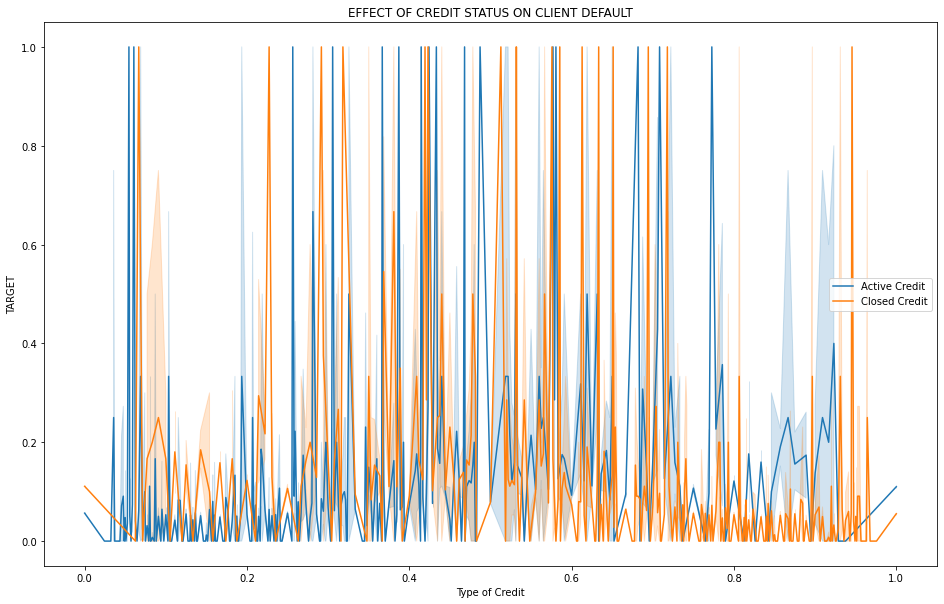

In [ ]:
########################################################## Section 1.2 Visualizing of Response Variable ############################################################

### I have plotted 2 different graphs on same features in order to get better idea.

########## Graph 1 Lineplot ##########


plt.figure(figsize=(16,10))
sns.lineplot(x='CRDT_ACTIVE_PROP',y='TARGET',data=application_train,label='Active Credit')
sns.lineplot(x='CRDT_CLOSED_PROP',y='TARGET',data=application_train,label='Closed Credit')



plt.title('EFFECT OF CREDIT STATUS ON CLIENT DEFAULT')
plt.xlabel('Type of Credit')
plt.show()


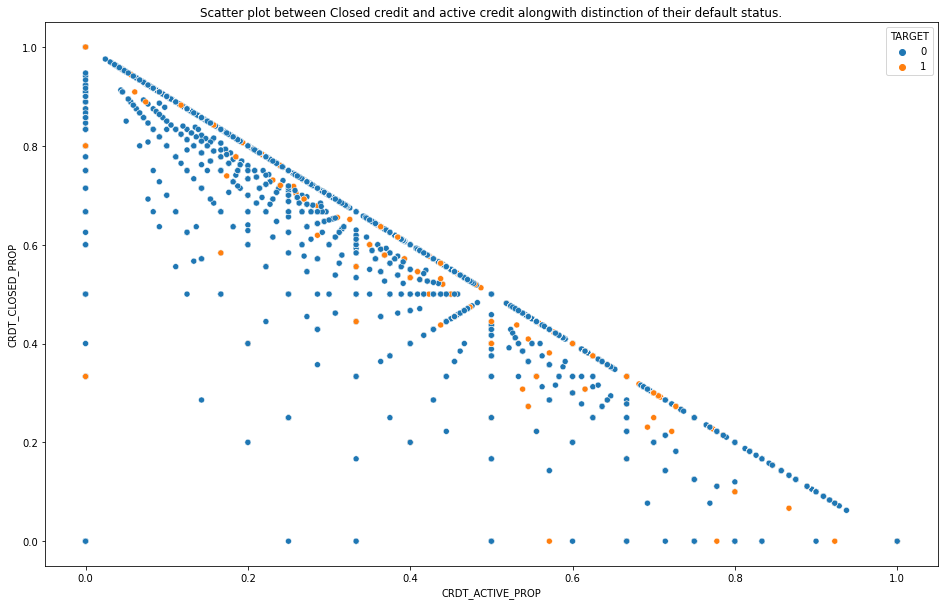

In [ ]:
########## Graph2 : Scatter plot ##########

plt.figure(figsize=(16,10))

plt.title('Scatter plot between Closed credit and active credit alongwith distinction of their default status.')
sns.scatterplot(x=application_train['CRDT_ACTIVE_PROP'],y=application_train['CRDT_CLOSED_PROP'],hue=application_train['TARGET'])

plt.show()

### **Answer for Part 1.2:**

The Response variable in our dataset is **'TARGET'**. This is a binary class variable.


*   **Y= 1** represents those clients which have payment difficulty.
*   **Y= 0** represents those clients who are capable of repayment.



# **Section 2: Logistic Regression Model**

In [ ]:
# SECTION 2: MODEL CONSTRUCTION USING LOGISTIC REGRESSION

application_train = application_train.fillna(0)

#target = application_train['TARGET']
#target = target.to_frame()
#application_train= application_train.drop(columns=['TARGET'])

# SPLIT

training, test = train_test_split(application_train,train_size=0.7,random_state=1)

training.shape,test.shape


((215257, 143), (92254, 143))

In [ ]:
# 'UNKNOWN' CATEGORICAL VARIABLE HAD ONLY 2 OCCURENCES IN NAME_FAMILY_STATUS COLUMN AND 
# AFTER SPLITTING BOTH OF THEM WENT TO TRAINING DATASET AND DUE TO THIS AFTER NO OF COLUMNS WE GOT AFTER DMATRICES WERE DIFFERENT IN BOTH TRAINING AND TEST SET.
# SO some extra codes are written.

training.index[training['NAME_FAMILY_STATUS'] == 'Unknown'].tolist()
training= training.append(test.loc[64282,:])
test = test.append(training.loc[41982,:])
training = training.drop(index=[41982])
test= test.drop(index=[64282])

# Dmatrices

y_train,x_train = dmatrices('TARGET~ENTRANCES_MEDI+NONLIVINGAREA_MODE+AMT_CREDIT_MAX_OVERDUE+AMT_REQ_CREDIT_BUREAU_WEEK+AMT_DRAWINGS_CURRENT+AMT_TOTAL_RECEIVABLE+LIVINGAPARTMENTS_MEDI+COMMONAREA_MODE+DAYS_EMPLOYED+FLAG_EMP_PHONE+DEF_30_CNT_SOCIAL_CIRCLE+OBS_30_CNT_SOCIAL_CIRCLE+EXT_SOURCE_2+REGION_RATING_CLIENT+AMT_GOODS_PRICE+AMT_CREDIT+REG_REGION_NOT_WORK_REGION+REG_CITY_NOT_WORK_CITY+FLOORSMAX_AVG+ELEVATORS_AVG+CNT_INSTALMENT_FUTURE+INSTALLMENT_PAID+EXT_SOURCE_3+CRDT_CARD_PROP+FLOORSMIN_AVG+FLOORSMIN_MEDI+EXT_SOURCE_1+OCCUPATION_TYPE+CODE_GENDER+DAYS_REGISTRATION+NAME_FAMILY_STATUS+NAME_HOUSING_TYPE+OWN_CAR_AGE+AMT_INCOME_TOTAL+FLAG_WORK_PHONE+FLAG_OWN_REALTY+C(NAME_CONTRACT_TYPE)+CNT_FAM_MEMBERS+C(NAME_TYPE_SUITE)+WEEKDAY_APPR_PROCESS_START+DAYS_LAST_PHONE_CHANGE',training,return_type='dataframe')
y_test,x_test =   dmatrices('TARGET~ENTRANCES_MEDI+NONLIVINGAREA_MODE+AMT_CREDIT_MAX_OVERDUE+AMT_REQ_CREDIT_BUREAU_WEEK+AMT_DRAWINGS_CURRENT+AMT_TOTAL_RECEIVABLE+LIVINGAPARTMENTS_MEDI+COMMONAREA_MODE+DAYS_EMPLOYED+FLAG_EMP_PHONE+DEF_30_CNT_SOCIAL_CIRCLE+OBS_30_CNT_SOCIAL_CIRCLE+EXT_SOURCE_2+REGION_RATING_CLIENT+AMT_GOODS_PRICE+AMT_CREDIT+REG_REGION_NOT_WORK_REGION+REG_CITY_NOT_WORK_CITY+FLOORSMAX_AVG+ELEVATORS_AVG+CNT_INSTALMENT_FUTURE+INSTALLMENT_PAID+EXT_SOURCE_3+CRDT_CARD_PROP+FLOORSMIN_AVG+FLOORSMIN_MEDI+EXT_SOURCE_1+OCCUPATION_TYPE+CODE_GENDER+DAYS_REGISTRATION+NAME_FAMILY_STATUS+NAME_HOUSING_TYPE+OWN_CAR_AGE+AMT_INCOME_TOTAL+FLAG_WORK_PHONE+FLAG_OWN_REALTY+C(NAME_CONTRACT_TYPE)+CNT_FAM_MEMBERS+C(NAME_TYPE_SUITE)+WEEKDAY_APPR_PROCESS_START+DAYS_LAST_PHONE_CHANGE',test,return_type='dataframe')




In [ ]:
########################################################## Section 2.1 Construction of Model ############################################################

# I have experimented Logistic Regression using two methods. First one involves use of sm.Logit() and other one uses smf.glm(). Both reveals nearly same coefficients..

###### Method1: Logistic Regression using sm.Logit

logit = sm.Logit(y_train,x_train).fit()
logit.summary()

         Current function value: 0.254430
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               215257
Model:                          Logit   Df Residuals:                   215178
Method:                           MLE   Df Model:                           78
Date:                Fri, 11 Feb 2022   Pseudo R-squ.:                 0.09241
Time:                        20:17:12   Log-Likelihood:                -54768.
converged:                      False   LL-Null:                       -60345.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    -30.0409      1.822    -16.491      0.000     -33.611     -26.471
OCCUPATION_TYPE[T.Accountants]                -0.1553      0.062     -2.520      0.012      -0.276      -0.035
OCCUPATION_TYPE[T.Cleaning staff]              0.0658      0.066      0.992      0.321      -0.064       0.196
OCCUPATION_TYPE[T.Cooking staff]               0.1537      0.058      2.665      0.008       0.041       0.267
OCCUPATION_TYPE[T.Core staff]                 -0.1337      0.038     -3.533      0.000      -0.208      -0.060
OCCUPATION_TYPE[T.Drivers]                     0.2097      0.038      5.461      0.000       0.134       0.285
OCCUPATION_TYPE[T.HR staff]                    0.0891      0.213      0.419      0.675      -0.328       0.506
OCCUPATION_TYPE[T.High skill tech staff]      -0.1308      0.053     -2.452      0.014      -0.235      -0.026
OCCUPATION_TYPE[T.IT staff]                   -0.1180      0.218     -0.540      0.589      -0.546       0.310
OCCUPATION_TYPE[T.Laborers]                    0.1905      0.029      6.608      0.000       0.134       0.247
OCCUPATION_TYPE[T.Low-skill Laborers]          0.3532      0.077      4.584      0.000       0.202       0.504
OCCUPATION_TYPE[T.Managers]                   -0.0158      0.042     -0.377      0.706      -0.098       0.066
OCCUPATION_TYPE[T.Medicine staff]             -0.0057      0.058     -0.098      0.922      -0.119       0.108
OCCUPATION_TYPE[T.Private service staff]      -0.0477      0.099     -0.483      0.629      -0.241       0.146
OCCUPATION_TYPE[T.Realty agents]               0.1893      0.157      1.203      0.229      -0.119       0.498
OCCUPATION_TYPE[T.Sales staff]                 0.1017      0.033      3.089      0.002       0.037       0.166
OCCUPATION_TYPE[T.Secretaries]                 0.2185      0.126      1.740      0.082      -0.028       0.465
OCCUPATION_TYPE[T.Security staff]              0.1217      0.054      2.247      0.025       0.016       0.228
OCCUPATION_TYPE[T.Waiters/barmen staff]        0.3129      0.106      2.965      0.003       0.106       0.520
CODE_GENDER[T.M]                               0.2149      0.021     10.372      0.000       0.174       0.256
CODE_GENDER[T.XNA]                           -12.0393    933.451     -0.013      0.990   -1841.570    1817.491
NAME_FAMILY_STATUS[T.Married]                 -0.1643      0.026     -6.207      0.000      -0.216      -0.112
NAME_FAMILY_STATUS[T.Separated]                0.0314      0.042      0.754      0.451      -0.050       0.113
NAME_FAMILY_STATUS[T.Single / not married] -6.598e-05      0.034     -0.002      0.998      -0.067       0.067
NAME_FAMILY_STATUS[T.Unknown]                -20.7708   1.18e+05     -0.000      1.000   -2.31e+05    2.31e+05
NAME_FAMILY_STATUS[T.Widow]                   -0.1644      0.051     -3.223      0.001      -0.264      -0.064
NAME_HOUSING_TYPE[T.Ho

In [ ]:
# Reference 4 for this method

###### Method 2: Logistic Regression using glm function. Both the methods gives same coefficient
modelx = smf.glm('TARGET~ENTRANCES_MEDI+NONLIVINGAREA_MODE+AMT_CREDIT_MAX_OVERDUE+AMT_REQ_CREDIT_BUREAU_WEEK+AMT_DRAWINGS_CURRENT+AMT_TOTAL_RECEIVABLE+LIVINGAPARTMENTS_MEDI+COMMONAREA_MODE+DAYS_EMPLOYED+FLAG_EMP_PHONE+DEF_30_CNT_SOCIAL_CIRCLE+OBS_30_CNT_SOCIAL_CIRCLE+EXT_SOURCE_2+REGION_RATING_CLIENT+AMT_GOODS_PRICE+AMT_CREDIT+REG_REGION_NOT_WORK_REGION+REG_CITY_NOT_WORK_CITY+FLOORSMAX_AVG+ELEVATORS_AVG+CNT_INSTALMENT_FUTURE+INSTALLMENT_PAID+EXT_SOURCE_3+CRDT_CARD_PROP+FLOORSMIN_AVG+FLOORSMIN_MEDI+EXT_SOURCE_1+OCCUPATION_TYPE+CODE_GENDER+DAYS_REGISTRATION+NAME_FAMILY_STATUS+NAME_HOUSING_TYPE+OWN_CAR_AGE+AMT_INCOME_TOTAL+FLAG_WORK_PHONE+FLAG_OWN_REALTY+C(NAME_CONTRACT_TYPE)+CNT_FAM_MEMBERS+C(NAME_TYPE_SUITE)+WEEKDAY_APPR_PROCESS_START+DAYS_LAST_PHONE_CHANGE',data= training,family=sm1.families.Binomial())

result = modelx.fit()


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               215257
Model:                            GLM   Df Residuals:                   215178
Model Family:                Binomial   Df Model:                           78
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54768.
Date:                Fri, 11 Feb 2022   Deviance:                   1.0954e+05
Time:                        16:41:58   Pearson chi2:                 1.03e+14
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    -30.0409      1.822    -16.491      0.000     -33.611     -26.471
OCCUPATION_TYPE[T.Accountants]                -0.1553      0.062     -2.520      0.012      -0.276      -0.035
OCCUPATION_TYPE[T.Cleaning staff]              0.0658      0.066      0.992      0.321      -0.064       0.196
OCCUPATION_TYPE[T.Cooking staff]               0.1537      0.058      2.665      0.008       0.041       0.267
OCCUPATION_TYPE[T.Core staff]                 -0.1337      0.038     -3.533      0.000      -0.208      -0.060
OCCUPATION_TYPE[T.Drivers]                     0.2097      0.038      5.461      0.000       0.134       0.285
OCCUPATION_TYPE[T.HR staff]                    0.0891      0.213      0.419      0.675      -0.328       0.506
OCCUPATION_TYPE[T.High skill tech staff]      -0.1308      0.053     -2.452      0.014      -0.235      -0.026
OCCUPATION_TYPE[T.IT staff]                   -0.1180      0.218     -0.540      0.589      -0.546       0.310
OCCUPATION_TYPE[T.Laborers]                    0.1905      0.029      6.608      0.000       0.134       0.247
OCCUPATION_TYPE[T.Low-skill Laborers]          0.3532      0.077      4.584      0.000       0.202       0.504
OCCUPATION_TYPE[T.Managers]                   -0.0158      0.042     -0.377      0.706      -0.098       0.066
OCCUPATION_TYPE[T.Medicine staff]             -0.0057      0.058     -0.098      0.922      -0.119       0.108
OCCUPATION_TYPE[T.Private service staff]      -0.0477      0.099     -0.483      0.629      -0.241       0.146
OCCUPATION_TYPE[T.Realty agents]               0.1893      0.157      1.203      0.229      -0.119       0.498
OCCUPATION_TYPE[T.Sales staff]                 0.1017      0.033      3.089      0.002       0.037       0.166
OCCUPATION_TYPE[T.Secretaries]                 0.2185      0.126      1.740      0.082      -0.028       0.465
OCCUPATION_TYPE[T.Security staff]              0.1217      0.054      2.247      0.025       0.016       0.228
OCCUPATION_TYPE[T.Waiters/barmen staff]        0.3129      0.106      2.965      0.003       0.106       0.520
CODE_GENDER[T.M]                               0.2149      0.021     10.372      0.000       0.174       0.256
CODE_GENDER[T.XNA]                           -18.7934   1.66e+04     -0.001      0.999   -3.25e+04    3.25e+04
NAME_FAMILY_STATUS[T.Married]                 -0.1643      0.026     -6.207      0.000      -0.216      -0.112
NAME_FAMILY_STATUS[T.Separated]                0.0314      0.042      0.754      0.451      -0.050       0.113
NAME_FAMILY_STATUS[T.Single / not married] -6.598e-05      0.034     -0.002      0.998      -0.067       0.067
NAME_FAMILY_STATUS[T.Unknown]                -18.9861   2.92e+04     -0.001      0.999

In [ ]:
################################################################### Section 2.2 Interpretation of Model #####################################################################

### **Section 2.2 Answer**

Firstly, we observe that Our intercept coefficient is less than zero. this tells us that probability of having outcome will be less than 0.5.

Now, lets see coefficients of other variables.



1.   Those variables having coefficients greater than 0( Let's represent coeff as b): In such cases a **unit change** in **X** will increase the logit or logit odd ratio by b units, if all other variables are kept fixed

  eg: **FLAG_EMP_PHONE** has coeff equal to 28.5288. Therfore a unit change in This variable will bring 28.5288 increase in Logit.
  In other words, Increase **FLAG_EMP_PHONE** will increase the odds of Y=1     against  Y=0 

  Some other variables are: **Name_type_suite**( All the 5 category variables have b >0),**Livingapartments_medi**,**Occupationtype**(Low skill Labor) etc.

2. Those variables hvaing coefficients equal to or very near to zero, suggest that Logit or in other words Y doesn't depend on these variable. Therefore, there is no dependence and effect of such variables and there existence is of no use.

  eg: AMT_INCOME_TOTAL has coeff of 3.346e-08 , which is nearly equal to 0. So, chnages in this variable will have no effect on logit, or in other words our Y.

  Some other varibales are : **Amt good price, Amt credit , Days employed**.

3. Those variables having coefficients <0 ( lets represent coeff as b): In such cases unit change in X will reduce the logit or logit odd ratio by b units.

  eg: NAME_FAMILY_STATUS has coeff = -20.7708. Thus, a unit change in this variable will reduce logit by -20.7708.
  In Laymann terms, Increase in this vaibale will reduce the odds of Y=1 against Y=0.

Some other variables are: Occupation type(Account, Core staff, high skills tech staff),Code gender.


**Note: All the values stated above are taken from sm.logit model.**

# **SECTION 3 MODEL Evaluation** :

In [ ]:
################################################################### SECTION 3.1 CONFUSION MATRIX  ####################################################

logit.predict()
# PREDICTION OF TRAINING DATASET
predict_label_train = pd.DataFrame(np.zeros(shape=(215257,1)), columns = ['TARGET'])
predict_label_train.iloc[logit.predict()>=0.5] = 1
predict_label_train

# PREDICTION OF TESTING DATASET
predict_label_test = pd.DataFrame(np.zeros(shape=(92254,1)),columns=['TARGET'])
predict_label_test.iloc[logit.predict(x_test)>=0.5]=1



# Confusion matrix of test set

confusion_matrix(y_test,predict_label_test)

array([[84769,    19],
       [ 7444,    22]])

In [ ]:
predict

In [ ]:
#################################################################### Section 3.2 Explanation #################################################################################

**Section 3.2 Answer:-**


**Strength**: One strength we can observe from the graph is that our model has high True negative.

**Weakness** : One obvious weakness we can see that , is the fact that our False Negative is quite high.

**Weakness explanation** : Since , we have High FN , this means that those customer which actually can't pay , are being recognised as non-defaulters by the model.
Due to this, Home credit group will have a tough time dealing with such customers. Therfore, the confusion matrix shows a major weakness in our model.

In [ ]:
ytest=np.array([1,1,1,0,1,0,0,1,0,0])
ypred = np.array([0.880797,1,1,2.06E-09,4.25E-18,0.999955,1,1,4.54E-05,2.06E-09])
ypred2= np.array([1,1,1,0,0,1,1,1,0,0])

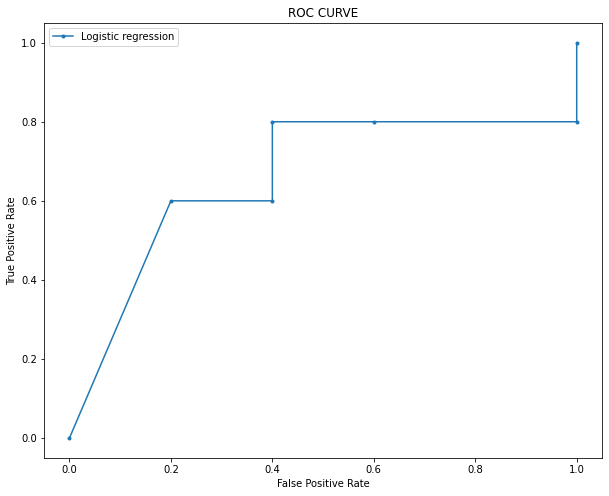

In [ ]:

######################################################################## Section 3.3 Graphic Illustartion of Performance ###########################################################

fpr_gm, tpr_gm, thresholds = roc_curve(ytest, ypred)

#print(' Area under the curve is ',roc_auc_score(y_test,logit.predict(x_test)))

plt.figure(figsize=(10,8))
plt.plot(fpr_gm, tpr_gm, marker='.', label='Logistic regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC CURVE")
plt.legend()
plt.show()


Area under the curve is : 0.7351470617989615

In [ ]:
####################################################################### Section 3.4 Computing the Performance Measure #########################################################

precision = precision_score(y_test,predict_label_test)
recall = recall_score(y_test,predict_label_test)
f1score = f1_score(y_test,predict_label_test)
accuracy = accuracy_score(y_test,predict_label_test)
misclassification_rate = 1 - accuracy_score(y_test,predict_label_test)


prf_metr_1 = [precision,recall,f1score,accuracy,misclassification_rate]
print('Precison is {}, Recall is {}, Misclassification rate is {}, accuracy is {} and F1-score is {}'.format(precision,recall,misclassification_rate,accuracy,f1score))


Precison is 0.5365853658536586, Recall is 0.0029466916688990086, Misclassification rate is 0.08089622130205731, accuracy is 0.9191037786979427 and F1-score is 0.005861196216864259


In [ ]:
########################################################################### Section 3.5 Suitable Performance Measure

**Section 3.5 Ans:**

If i were to choose 2 performance measure, then i would select Precision and recall.

One major reason of selecting these and rejecting others such as accuracy and misclassification rate, is due to the fact that latter measures don't perform well in imbalanced dataset.
For Imbalanced dataset, Precision and Recall are the best ones.

Furthermore, Precison accurately tells us our relationship with False posotive. In other words, high Precision leads to low False positive.
Similarly, Accuracy tells us our relationship between False negative.
High accuracy leads to low False Negative.

By both these measures, we can tell FP and FN of our model which are very important for dataset.

# **SECTION 4 Alternate MODEL EVALUATION:-**

In [ ]:
y_train.values.shape

(215257, 1)

In [ ]:
# Sub-Section 4.1 and 4.2

# METHOD CHOSEN : LDA

#LDA  Lets tune our model and cross validate our hyper parameter(which happens to be named as solver in LDA ). For simplicity we are using 5 fold cross validation.

model_alt = LDA(n_components=1)
parameter_1 = {'solver':('svd','lsqr','eigen')}


grid_search = GridSearchCV(estimator=model_alt,param_grid=parameter_1,scoring='accuracy',n_jobs= -1,cv=5)  # Reference 5

results_alt = grid_search.fit(x_train,y_train)

print('Best tuned parameter(model)is {} and it score is {}'.format(results_alt.best_params_,results_alt.best_score_))

###### RESULT : BEST SOLVER IS SVD and it's corresponding score is 0.91925.Hence, we will choose SVD.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py", line 603, in fit
    covariance_estimator=self.covariance_estimator,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py", line 440, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/usr/local/lib

Best tuned parameter(model)is {'solver': 'svd'} and it score is 0.9192500128944598


In [ ]:
# Section 4.3

y_predict = results_alt.predict(x_test)

confusion_matrix(y_test,y_predict)

array([[84715,    73],
       [ 7416,    50]])

Area under the curve is 0.7330192480447064


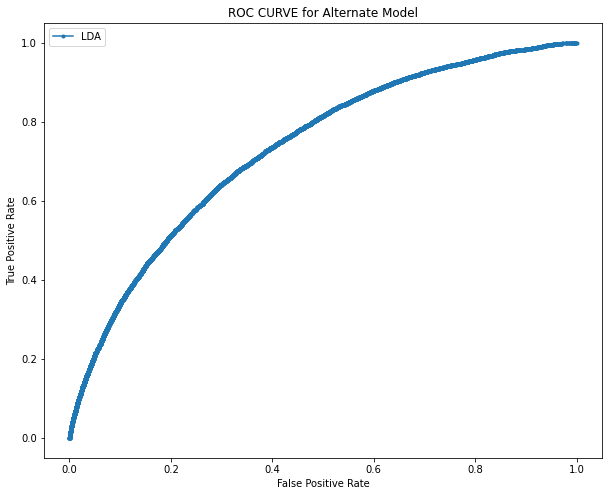

In [ ]:
# Section 4.4

proba= results_alt.predict_proba(x_test)
dff = pd.DataFrame(proba,columns=['a','b'])
dff= pd.concat([dff,pd.DataFrame(y_predict,columns=['Target'])],axis=1)
y_prob = dff.iloc[:,0:2].min(axis=1)

fp,tp,th= roc_curve(y_test,y_prob)

print('Area under the curve is {}'.format(roc_auc_score(y_test,y_prob)))

plt.figure(figsize=(10,8))
plt.plot(fp, tp, marker='.', label='LDA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC CURVE for Alternate Model")
plt.legend()
plt.show()


Area under the curve for alternate model is 0.7330192480447064.

# **Section 5**

In [ ]:
# Performance metric Calculation for Alternate model

precision_1 = precision_score(y_test,y_predict)
recall_1 = recall_score(y_test,y_predict)
f1score_1 = f1_score(y_test,y_predict)
accuracy_1 = accuracy_score(y_test,y_predict)
misclassification_rate_1 = 1 - accuracy_score(y_test,y_predict)


prf_metr_2 = [precision_1,recall_1,f1score_1,accuracy_1,misclassification_rate_1]


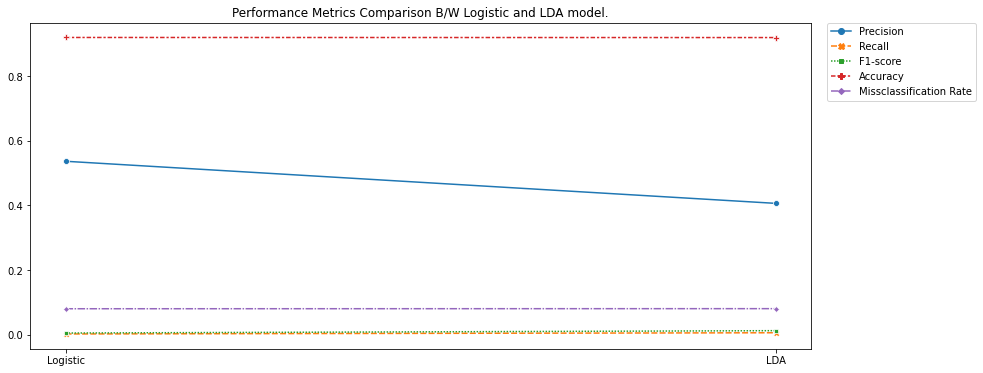

In [ ]:
############################################################################### Section 5.1 Comparing Performance Measure ###################################################

df_p = pd.DataFrame(np.array(prf_metr_1).T.reshape(-1,5),columns=['Precision',"Recall",'F1-score','Accuracy','Missclassification Rate'],index=['Logistic'])
df_p1 = pd.DataFrame(np.array(prf_metr_2).T.reshape(-1,5),columns=['Precision',"Recall",'F1-score','Accuracy','Missclassification Rate'],index=['LDA'])
df_p = pd.concat([df_p,df_p1],axis=0)

plt.figure(figsize=(14,6))
plt.title('Performance Metrics Comparison B/W Logistic and LDA model.')

sns.lineplot(data=df_p,markers=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

**Interpretation from graph :**



*   It can be clearly seen that Precision decreases as we move from Logistic model to LDA model.
*   Accuracy nearly reamin same


*   Likewise, Misclassification rate also remain nearly same.
*   Recall and F1-score follow same pattern, they increase as we move from logistic to Lda but not by a considerable amount.





In [ ]:
###################################################################### SECTION 5.2 #####################################################################

**Section 5.2 Answer:-**

According to question, Client is interested in that model which rejects the application who otherwise end up hvaing difficulty. In such a scenario, We will need to judge on the basis on Recall. Our reason for chossing this solely depends on False Negative and TP. So, models having higher Recall will have higher TP and lower FN.

So, according to the values, LDA model ( Alternate Model) is better as compared to Logistic one and thus, we will choose **LDA Model( Alternate Model ).**


In [ ]:
########################################################################## Section 5.3 #########################################################################3

**Section 5.3 Answer:-**

According to this question, Our client now wants such a model which doesn't reject application of individuals who may be capable of repayment. Here, we will need to judge on basis of Precision. Because, we need to decrease the False positive. So, we need models with high precision.

Comparing both the models, we see that Logistic regression model has higher Precision than the other and thus, we will choose **Logistic Regression Model.**

# **References:**

1. https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby

2. https://www.analyticsvidhya.com/blog/2020/03/groupby-pandas-aggregating-data-python/

3. https://stackoverflow.com/questions/60310864/replace-non-zero-values-in-a-single-column-pandas-dataframe

4. http://www.science.smith.edu/~jcrouser/SDS293/labs/lab4-py.html

5. https://machinelearningmastery.com/linear-discriminant-analysis-with-python/
